In [1]:
import pandas as pd
import seaborn as sns
import gc
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import pickle

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shaurya/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /Users/shaurya/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [2]:
# read in pickles created in ./notebooks/data_download.ipynb
df = pd.read_pickle('./data/master_data.pkl') # data with the patent claims
df_pats_w_sectors = pd.read_pickle('./data/pats_w_sectors.pkl') # data with the classifications

In [3]:
def merge_and_clean(df1, df2):
    '''
    Given two dataframes for my data, rename columns and merge data
    
    Parameters: 
    df1: 
    df2: 
    
    Returns:
    df: dataframe with the data downloaded and unzipped
    
    '''
    df1 = df1.drop(['field_title'], axis=1)
    df1 = df1.drop_duplicates()
    groups = df1.groupby(by='patent_id').count()
    singles = groups[groups.sector_title == 1]
    singles = singles.reset_index()
    ok_pats = df1.merge(singles, on='patent_id')
    ok_pats = ok_pats.drop(['sector_title_y'], axis=1)
    ok_pats = ok_pats.rename(columns={'sector_title_x':'sector'})
    ok_pats.patent_id = ok_pats.patent_id.astype('int64')
    df_merged = ok_pats.merge(df2, how='inner', on='patent_id')
    return df_merged

In [4]:
df_master = merge_and_clean(df_pats_w_sectors, df)

In [5]:
# Drop "other fiends" classification since I'm treating this as a lack of a classification
df_master = df_master[df_master.sector!='Other fields']
df_master

,patent_id,sector,text
0,10001556,Instruments,1. An FMCW radar apparatus comprising: a trans...
1,10001557,Instruments,1. A state recognizing device for recognizing ...
2,10001558,Instruments,"1. A fill level measurement device, comprising..."
3,10001559,Instruments,1. A method for detecting a concealed object i...
4,10001562,Instruments,"1. A distance-settable photoelectric sensor, c..."
...,...,...,...
1679378,9998144,Electrical engineering,1. A computer program product for generating a...
1679379,9998146,Electrical engineering,1. A communications method comprising: an emul...
1679380,9998148,Electrical engineering,"1. An apparatus for decoding, comprising: a me..."
1679381,9998149,Electrical engineering,1. A process comprising: (a.) receiving a data...


In [36]:
df_master["text"][0]

'1. An FMCW radar apparatus comprising: a transmission unit that transmits a transmission signal including a first frequency-rise time period whose frequency sequentially rises with a first modulated gradient, a first frequency-fall time period whose frequency sequentially falls with the first modulated gradient, a second frequency-rise time period whose frequency sequentially rises with a second modulated gradient different from the first modulated gradient, and a second frequency-fall time period whose frequency sequentially falls with the second modulated gradient; a reception unit that receives a reception signal resulting from reflection of the transmission signal by a target and outputs beat signals based on the transmission signal and the reception signal; a control unit that detects a target on the basis of the beat signals; and a power supply bias circuit that supplies power-supply voltage to at least the transmission unit and the control unit, among the transmission unit, the

In [6]:
df = df_master

In [7]:
df.head()

,patent_id,sector,text
0,10001556,Instruments,1. An FMCW radar apparatus comprising: a trans...
1,10001557,Instruments,1. A state recognizing device for recognizing ...
2,10001558,Instruments,"1. A fill level measurement device, comprising..."
3,10001559,Instruments,1. A method for detecting a concealed object i...
4,10001562,Instruments,"1. A distance-settable photoelectric sensor, c..."


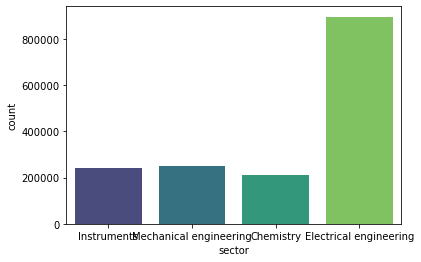

In [11]:
ax = sns.countplot(x='sector', data=df, palette='viridis')

In [12]:
# Take a look at the actual numbers for the counts.
sizes = pd.DataFrame()
sizes['sector'] = list(set(df.sector))
sizes['sector_count'] = [len(df[df.sector==sector]) for sector in sizes.sector]
sizes

,sector,sector_count
0,Electrical engineering,896813
1,Chemistry,211678
2,Instruments,240350
3,Mechanical engineering,249250


There is an imbalance favoring "Electrical engineering", but we have plenty of data, so I used a subset of the data to balance the classes.



In [13]:
# Take 200k from each class. I limited to this amount to help with computing times.
class_size = 200000
trimmed_df = pd.DataFrame()
for sector in sizes.sector:
    group = df[df.sector == sector][:class_size]
    trimmed_df = trimmed_df.append(group)
trimmed_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800000 entries, 392499 to 386169
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   patent_id  800000 non-null  int64 
 1   sector     800000 non-null  object
 2   text       800000 non-null  object
dtypes: int64(1), object(2)
memory usage: 24.4+ MB


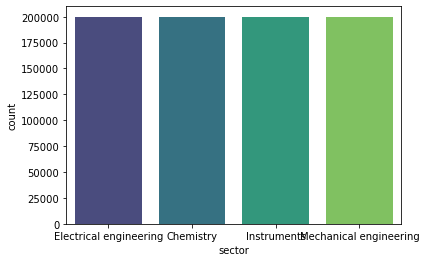

In [14]:
# Verify the classes are all equal.
ax = sns.countplot(x='sector', data=trimmed_df, palette='viridis')

In [15]:
# Do some memory management and split into X and y sets
del df
df = trimmed_df
y = df['sector']
X = df['text']
del trimmed_df
gc.collect()

10031

In [16]:
# Pickle the split dataset with all 4 classes
y.to_pickle('data/y_4class.pkl')
X.to_pickle('data/X_4class.pkl')

In [17]:
# Create training and test sets with all classes and then pickling y sets and x sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)
y_train.to_pickle('data/y_train_4class.pkl')
y_test.to_pickle('data/y_test_4class.pkl')
X_train.to_pickle('data/X_train_4class.pkl')
X_test.to_pickle('data/X_test_4class.pkl')

In [20]:
X_train.shape, X_test.shape

((640000,), (160000,))

------------

In [21]:
def preprocess_text(text):
    '''
    Given a string, returns tokenized and stemmed list of words
    
    Parameters: 
    text: string to be tokenized and stemmed
    
    Returns:
    keywords: list of stemmed tokens
    
    '''
    # Import packages and modules
    import pandas as pd
    from nltk.stem.porter import PorterStemmer
    from nltk.tokenize import RegexpTokenizer
    from nltk.corpus import stopwords

    # Tokenize words while ignoring punctuation
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    
    # Create stopwords
    stop_words = stopwords.words('english')
    custom_stops = ['claim', 'claims', 'method', 'comprising', 'comprises', 'including', 'includes', 'according']
    [stop_words.append(word) for word in custom_stops]

    # Lowercase and stem
    stemmer = PorterStemmer()
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item.lower()))
    
    # Remove stopwords
    keywords= [stem for stem in stemmed if stem not in stop_words]
    return stemmed

In [22]:
# Vectorize data
vec = TfidfVectorizer(analyzer=preprocess_text,
                      ngram_range=(1,3),
                      min_df=0.1,
                      max_df=0.9)

In [23]:
# Vectorize data for train and test sets, then pickle them for later
X_train_transformed = vec.fit_transform(X_train).toarray()

In [24]:
#pickle.dump(vec, open('./data/vec_4class.pkl', 'wb'))

In [25]:
#X_train_transformed = vec.fit_transform(X_train).toarray()
X_train = pd.DataFrame(X_train_transformed, columns = vec.get_feature_names())
#X_train.to_pickle('data/X_train_vect_4class.pkl')

X_test_transformed = vec.transform(X_test).toarray()
X_test = pd.DataFrame(X_test_transformed, columns = vec.get_feature_names())
#X_test.to_pickle('data/X_test_vect_4class.pkl')

In [29]:
len(X_train.columns)

81

In [30]:
X_train.columns

Index(['2', '3', 'an', 'apparatu', 'are', 'arrang', 'as', 'at', 'b', 'base',
       'be', 'between', 'by', 'c', 'commun', 'configur', 'connect', 'control',
       'correspond', 'coupl', 'data', 'defin', 'determin', 'devic', 'differ',
       'direct', 'dispos', 'each', 'end', 'extend', 'first', 'for', 'form',
       'from', 'gener', 'group', 'ha', 'have', 'in', 'includ', 'into', 'is',
       'least', 'locat', 'member', 'method', 'more', 'on', 'one', 'open',
       'oper', 'or', 'other', 'plural', 'portion', 'posit', 'process',
       'provid', 'receiv', 'respect', 'said', 'second', 'select', 'side',
       'signal', 'so', 'such', 'surfac', 'system', 'than', 'that', 'thereof',
       'through', 'two', 'unit', 'use', 'when', 'wherein', 'which', 'with',
       'within'],
      dtype='object')

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [50]:
logreg = LogisticRegression(random_state=42, n_jobs=1, 
                            max_iter=200, solver='lbfgs')
logreg.fit(X_train,y_train)
y_pred = logreg.predict(X_test)
train_acc = accuracy_score(y_train,logreg.predict(X_train))
test_acc = accuracy_score(y_test,y_pred)
print(train_acc,test_acc)

0.6376203125 0.63765625


In [51]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train,y_train)
y_pred2 = dt.predict(X_test)
train_acc2 = accuracy_score(y_train,dt.predict(X_train))
test_acc2 = accuracy_score(y_test,y_pred2)
print(train_acc2,test_acc2)

0.999896875 0.5705875


In [52]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train,y_train)
y_pred3 = rf.predict(X_test)
train_acc3 = accuracy_score(y_train,rf.predict(X_train))
test_acc3 = accuracy_score(y_test,y_pred3)
print(train_acc3,test_acc3)

0.999890625 0.69115625


In [60]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

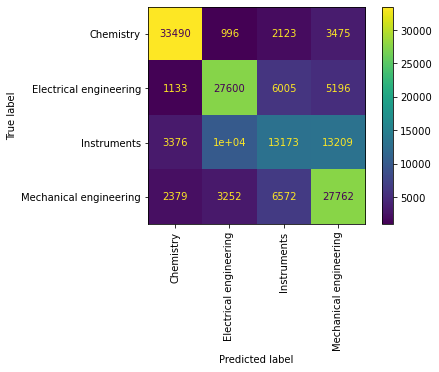

In [61]:
plot_confusion_matrix(logreg, X_test, y_test,xticks_rotation='vertical')

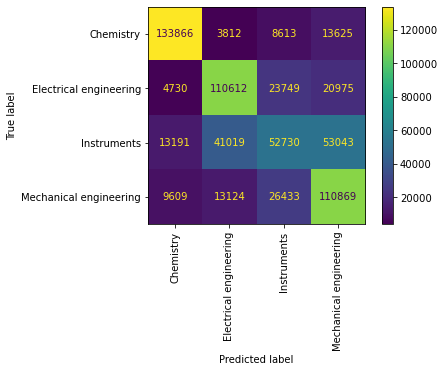

In [62]:
plot_confusion_matrix(logreg, X_train, y_train,xticks_rotation='vertical')

Text(0.5, 1.0, 'Feature Importance Top 20 - Logistic Regression')

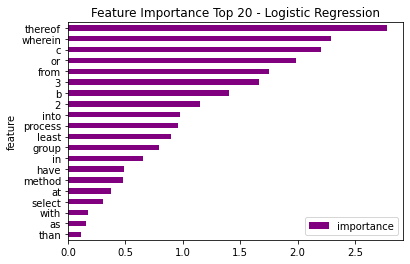

In [63]:
# get importance
feature_names = X_train.columns

# create dataframe of top features
feature_importance = pd.DataFrame(feature_names, columns = ['feature'])
feature_importance['importance'] = logreg.coef_[0]
feature_importance = feature_importance.sort_values(by = ['importance'], 
                                                    ascending=False)

# plot importance
n = 20
ax = feature_importance.iloc[:n].plot.barh(x='feature', y='importance', 
                                           color='purple').invert_yaxis()
plt.title(f'Feature Importance Top {n} - Logistic Regression')